# Notebook para o PAN - Atribuição Autoral - 2018

In [83]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#preprocessing and transformation
from sklearn.preprocessing import normalize, Normalizer, MaxAbsScaler, MinMaxScaler, LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier


from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.4.0-x86_64-i386-64bit
NumPy 1.14.0
SciPy 1.0.0
Scikit-Learn 0.19.1


### paths configuration

In [3]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [4]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [5]:
problems = readCollectionsOfProblems(inputDir);

In [6]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [7]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [8]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [9]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [11]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [12]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [13]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [14]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class ObfuscationTransformer(BaseEstimator):
    def __init__(self,re_from=r'(\b)(\w{0,2})\w+(\w{1,3})(\b)', re_to=r'\1\2XX\3\4', return_copy=True):
        self.re_from = re_from
        self.re_to = re_to

    def transform(self, X, y=None):
        X = np.array(X).copy();
        for i in range(len(X)):
            X[i] = re.sub(self.re_from,self.re_to, X[i])
        
        return X;

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [102]:
def runML(problem):
    print ("Problem: %s,  language: %s " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    cachedir = mkdtemp()
    pipeline = Pipeline([
        ('obs',ObfuscationTransformer(re_from=r'\w|\d',re_to='x')),
        ('vect',   TfidfVectorizer(
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l1',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ], memory=cachedir)
    
    
    t0 = time()
    pipeline.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))
        
    train_pred=pipeline.predict(train_docs);
    test_pred=pipeline.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append(
                {'unknown-text': test_filename[i],
                 'predicted-author': v
                }
                )
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    rmtree(cachedir)
    return {
                'problem-name'   : problem['problem'],
                "train_doc_size":len(train_docs),
                "language":problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                'AuthorCount':len(set(train_labels))
        };

In [103]:
result = [];
for problem in problems:
    result.append(runML(problem));
pd.DataFrame(result)

Problem: problem00001,  language: en 
done in 7.029s
Problem: problem00002,  language: en 
done in 3.252s
Problem: problem00003,  language: fr 
done in 8.105s
Problem: problem00004,  language: fr 
done in 2.858s
Problem: problem00005,  language: it 
done in 6.563s
Problem: problem00006,  language: it 
done in 3.139s
Problem: problem00007,  language: pl 
done in 9.120s
Problem: problem00008,  language: pl 
done in 4.379s
Problem: problem00009,  language: sp 
done in 6.741s
Problem: problem00010,  language: sp 
done in 3.086s


,AuthorCount,language,macro-f1,macro-precision,macro-recall,micro-accuracy,problem-name,train_doc_size
0,20,en,0.607,0.579,0.745,0.638,problem00001,140
1,5,en,0.557,0.583,0.650,0.524,problem00002,35
2,20,fr,0.683,0.669,0.742,0.735,problem00003,140
3,5,fr,0.719,0.766,0.753,0.667,problem00004,35
4,20,it,0.582,0.582,0.702,0.662,problem00005,140
5,5,it,0.632,0.630,0.683,0.804,problem00006,35
6,20,pl,0.473,0.475,0.574,0.505,problem00007,140
7,5,pl,0.738,0.711,0.778,0.867,problem00008,35
8,20,sp,0.748,0.751,0.808,0.761,problem00009,140
9,5,sp,0.860,0.853,0.873,0.906,problem00010,35


In [104]:
pd.DataFrame(result)[['macro-f1']].describe()

,macro-f1
count,10.000000
mean,0.659900
std,0.112098
min,0.473000
25%,0.588250
50%,0.657500
75%,0.733250
max,0.860000


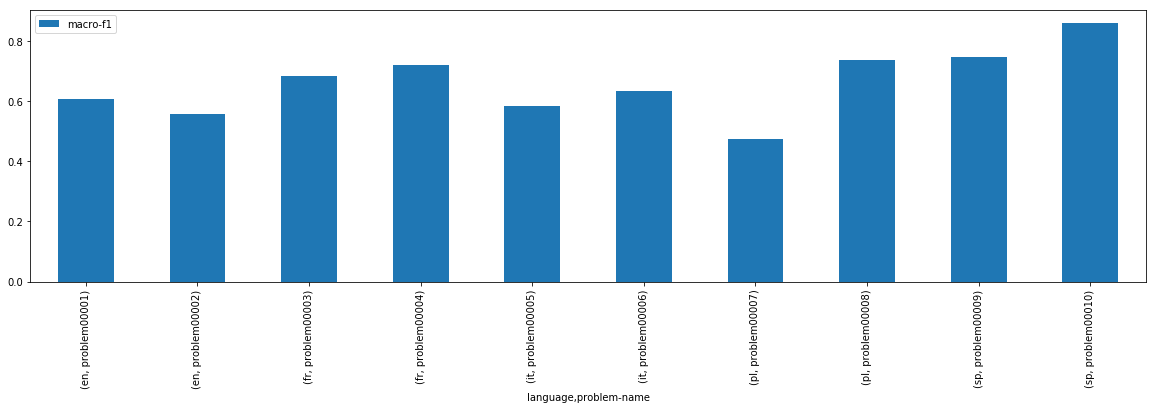

In [105]:
pd.DataFrame(result)\
    .sort_values(by=['language','problem-name'])[['language','problem-name','macro-f1']]\
    .plot(kind='bar', x=['language','problem-name'], legend=True, figsize=(20,5))

In [233]:
def runML(problem):
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    cachedir = mkdtemp()
    
    pipeline1 = Pipeline([
        ('vect',   TfidfVectorizer(
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    pipeline2 = Pipeline([
        ('obs',ObfuscationTransformer(re_from=r'\w',re_to='x')),
        ('vect',   TfidfVectorizer(
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegressionCV(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    pipeline3 = Pipeline([
        ('vect',   TfidfVectorizer(
                analyzer='word',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(1,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    t0 = time()
    if problem['language'] == 'en':
        clfFinal = pipeline1
        clfFinal.fit(train_docs, train_labels);
        train_pred=clfFinal.predict(train_docs);
        test_pred =clfFinal.predict(test_docs);
    else:
        for p in [pipeline1,pipeline2, pipeline3]:
            p.fit(train_docs, train_labels)

        xtrain_mix = np.hstack([p.predict_proba(train_docs) for p in [pipeline1, pipeline2, pipeline3]])
        xtest_mix  = np.hstack([p.predict_proba(test_docs) for p in [pipeline1, pipeline2, pipeline3]])

        clfFinal = Pipeline([
            ('pca', PCA(0.99)),
            ('clf',MLPClassifier(activation='identity',hidden_layer_sizes=(xtrain_mix.shape[1]), random_state=0))
        ]);
        clfFinal.fit(xtrain_mix, train_labels);

        train_pred=clfFinal.predict(xtrain_mix);
        test_pred =clfFinal.predict(xtest_mix);
    print("done in %0.3fs \n" % (time() - t0))
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append(
                {'unknown-text': test_filename[i],
                 'predicted-author': v
                }
                )
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    rmtree(cachedir)
    return {
                'problem-name'   : problem['problem'],
                "train_doc_size":len(train_docs),
                "language":problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                'AuthorCount':len(set(train_labels))
        };

In [234]:
result = [];
for problem in problems:
    result.append(runML(problem));
pd.DataFrame(result)

Problem: problem00001,  language: en, 
done in 8.368s 

Problem: problem00002,  language: en, 
done in 2.308s 

Problem: problem00003,  language: fr, 
done in 18.303s 

Problem: problem00004,  language: fr, 
done in 4.912s 

Problem: problem00005,  language: it, 
done in 23.169s 

Problem: problem00006,  language: it, 
done in 6.940s 

Problem: problem00007,  language: pl, 
done in 23.392s 

Problem: problem00008,  language: pl, 
done in 5.281s 

Problem: problem00009,  language: sp, 
done in 21.960s 

Problem: problem00010,  language: sp, 
done in 9.439s 



,AuthorCount,language,macro-f1,macro-precision,macro-recall,micro-accuracy,problem-name,train_doc_size
0,20,en,0.605,0.582,0.745,0.638,problem00001,140
1,5,en,0.535,0.567,0.633,0.476,problem00002,35
2,20,fr,0.659,0.670,0.727,0.633,problem00003,140
3,5,fr,0.754,0.786,0.830,0.667,problem00004,35
4,20,it,0.527,0.524,0.634,0.625,problem00005,140
5,5,it,0.738,0.752,0.729,0.870,problem00006,35
6,20,pl,0.513,0.529,0.599,0.602,problem00007,140
7,5,pl,0.760,0.733,0.800,0.933,problem00008,35
8,20,sp,0.648,0.648,0.762,0.709,problem00009,140
9,5,sp,0.815,0.821,0.814,0.859,problem00010,35


In [236]:
pd.DataFrame(result)[['macro-f1']].describe()

,macro-f1
count,10.000000
mean,0.655400
std,0.108948
min,0.513000
25%,0.552500
50%,0.653500
75%,0.750000
max,0.815000


In [220]:
problem = problems[9]

In [221]:
print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))

train_docs, train_labels, _   = zip(*problem['candidates'])
problem['training_docs_size'] = len(train_docs);
test_docs, _, test_filename   = zip(*problem['unknown'])

Problem: problem00010,  language: sp, 


In [222]:
#code from baseline
gt = {}
with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs, _, test_filename = zip(*problem['unknown'])
test_labels = [gt[v] for v in test_filename]

In [223]:
pipeline1 = Pipeline([
        ('vect',   TfidfVectorizer(
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])

In [224]:
pipeline2 = Pipeline([
        ('obs',ObfuscationTransformer(re_from=r'\w|\d',re_to='x')),
        ('vect',   TfidfVectorizer(
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l1',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])

In [225]:
pipeline3 = Pipeline([
        ('vect',   TfidfVectorizer(
                analyzer='word',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(1,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])

In [226]:
t0 = time()
pipeline1.fit(train_docs, train_labels);
pipeline2.fit(train_docs, train_labels);
pipeline3.fit(train_docs, train_labels);
print("done in %0.3fs \n" % (time() - t0))

done in 2.518s 



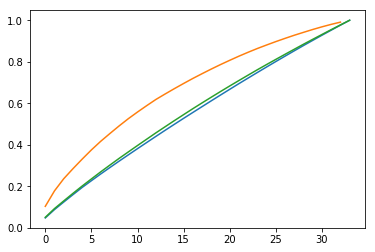

In [227]:
plt.plot(pipeline1.named_steps['transf'].explained_variance_ratio_.cumsum(),label="1");
plt.plot(pipeline2.named_steps['transf'].explained_variance_ratio_.cumsum());
plt.plot(pipeline3.named_steps['transf'].explained_variance_ratio_.cumsum());

In [228]:
xtrain_mix = np.hstack([p.predict_proba(train_docs) for p in [pipeline1, pipeline2, pipeline3]])
xtest_mix  = np.hstack([p.predict_proba(test_docs) for p in [pipeline1, pipeline2, pipeline3]])

In [229]:
#clfFinal = LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg', C=0.1);
clfFinal = Pipeline([
    #('prepro', Normalizer(norm='l2')),
    #('pca', PCA(0.99)),
    ('clf',MLPClassifier(activation='identity',hidden_layer_sizes=(xtrain_mix.shape[1]), random_state=0))
]);
#clfFinal = MLPClassifier(activation='identity',hidden_layer_sizes=(xtrain_mix.shape[1]), random_state=0)

clfFinal.fit(xtrain_mix, train_labels);

train_pred=clfFinal.predict(xtrain_mix);
test_pred =clfFinal.predict(xtest_mix);

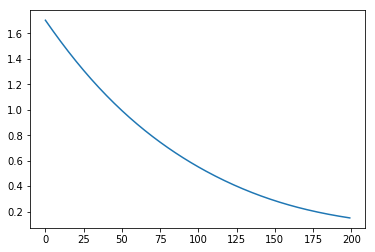

In [230]:
plt.plot(clfFinal.named_steps['clf'].loss_curve_)

In [231]:
print(np.sum(np.array(train_pred) == np.array(train_labels))*1.0/len(train_labels))
print(np.sum(np.array(test_pred) == np.array(test_labels))*1.0/len(test_labels))

1.0
0.875


In [232]:
test_pred =clfFinal.predict(xtest_mix);
f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, test_pred)  })
results = [{ 'caso' : 'total',
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3)
             }]
for clf in [pipeline1, pipeline2, pipeline3]:
    p = clf.predict(test_docs)
    f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, p)  })
    results.append({
                'caso' : clf.named_steps['vect'].analyzer,
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3)
             });

pd.DataFrame(results)

,caso,macro-f1,macro-precision,macro-recall,micro-accuracy
0,total,0.852,0.856,0.873,0.875
1,char,0.778,0.783,0.785,0.844
2,char,0.775,0.768,0.785,0.813
3,word,0.588,0.599,0.609,0.703


In [180]:
df=pd.DataFrame(
    zip(
        pipeline1.predict(test_docs),
        pipeline2.predict(test_docs),
        pipeline3.predict(test_docs),
        test_pred,
        test_labels
    ),
    columns=['p1','p2','p3','ens', 'truth'])

In [ ]:
df.p1  = np.where(df.p1 == df.truth,1,0)
df.p2  = np.where(df.p2 == df.truth,1,0)
df.p3  = np.where(df.p3 == df.truth,1,0)
df.ens = np.where(df.ens == df.truth,1,0)

In [ ]:
df.groupby(by='truth').agg(np.sum).reset_index()